## Spectral Clustering and Semi-Supervised Learning

#### This notebook contains different values and imports that can be used in this practical session.
#### Please keep the same variable names when provided in your report to make the work of teaching assistants easier. 
#### You can still change the values given or the sizes of the datasets treated if you believe it is usefull to illustrate your point.

#### You can directly edit the markdown boxes to add your comments and answers to the questions

### Note : You may want to skip the Mnist part Question 8, which may take long time.

In [1]:
# Question 1 (imports and advised values):
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

n_samples = 200 # You can change these values
noise_level_list = [.05,.1,.2] # You can change these values

### Question 1 : Complete the code in the box below

In [2]:
# import data, first use the noise = 0.05
import sklearn.datasets as datasets
# number of different noise levels
N = len(noise_level_list)
# list to store different data sets
lis_noisy_moons = []
for noise in noise_level_list:
    lis_noisy_moons.append(datasets.make_moons(n_samples=n_samples, noise=noise))

In [3]:
# check
noisy_moons = lis_noisy_moons[0]
type(noisy_moons), len(noisy_moons), noisy_moons[0].shape,  noisy_moons[1].shape

(tuple, 2, (200, 2), (200,))

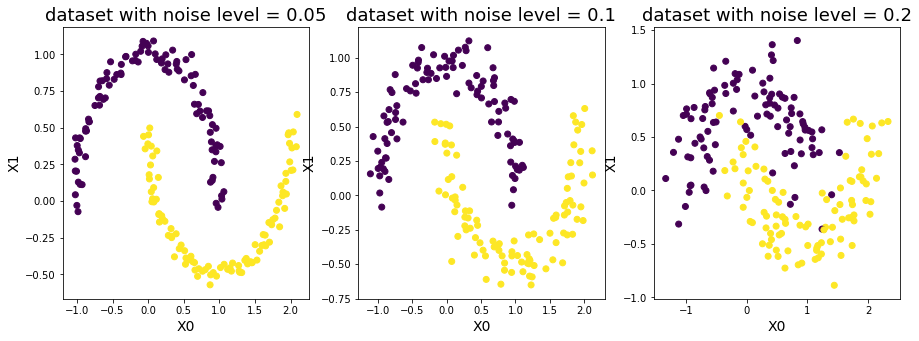

In [4]:
# plot 
plt.figure(figsize=(15, 5))

for i in range(1, N+1):
    # take data out
    noisy_moons = lis_noisy_moons[i-1]
    X, y_true = noisy_moons[0], noisy_moons[1]
    
    plt.subplot(1, N, i)

    plt.scatter(x=X[:,0], y=X[:,1], c=y_true)
    plt.title("dataset with noise level = " + str(noise_level_list[i-1]), fontsize=18)
    plt.xlabel("X0", fontsize=14)
    plt.ylabel("X1", fontsize=14)

Increasing the noise, the data points become more loose.

In [5]:
# Question 2 :
# from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
n_neighbors_list = [1,5,10] # You can change these values

### Question 2 : Complete the code in the box below

### KNN : try a cluster n_neighbors = 6

In [6]:
#visualize the graph
def draw_adj_mat(adj_mat, data):
    row, col = adj_mat.shape
    for i in range(row):
        for j in range(col):
            if adj_mat[i,j] == 1 :
                plt.plot([data[i][0], data[j][0]], [data[i][1], data[j][1]], 'r')

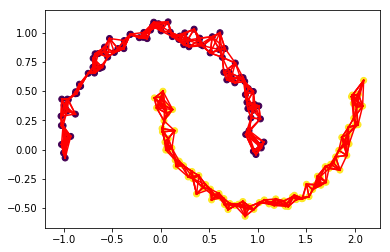

In [7]:
#set the number of neighbors
k = 6
#get one dataset
moons = lis_noisy_moons[0]
X, y_true = moons[0], moons[1]
knn_adj_mat = kneighbors_graph(X, n_neighbors=k, n_jobs=4)

plt.subplot(1, 1, 1)
plt.scatter(x=X[:,0], y=X[:,1], c=y_true)
draw_adj_mat(knn_adj_mat, X)

### visualize several graphs by varying k in the KNN  

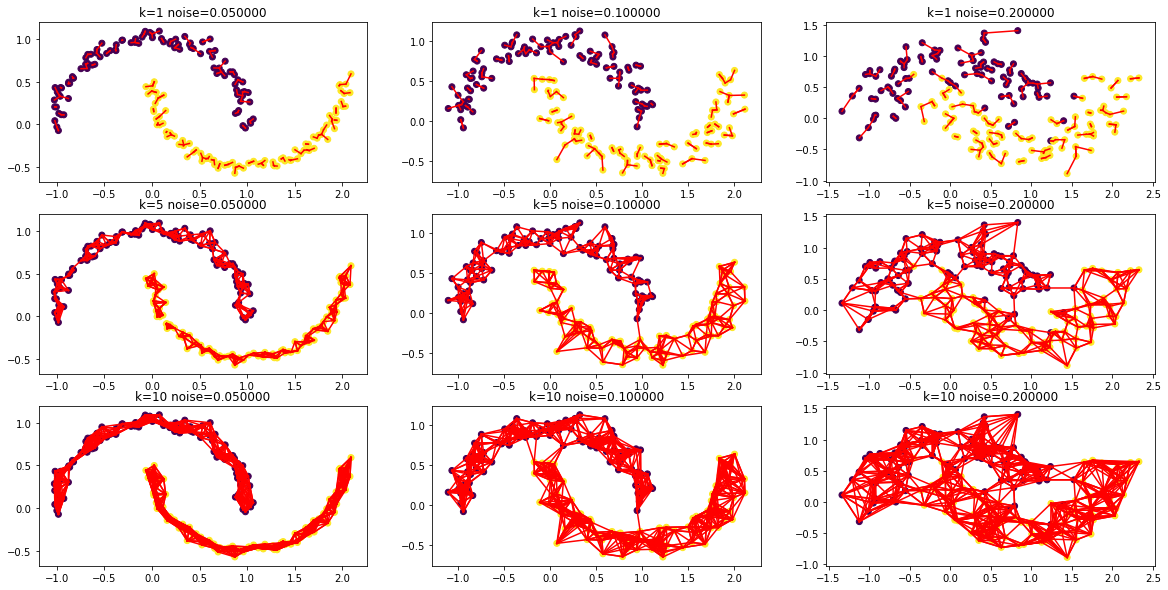

In [8]:
lis_knn = n_neighbors_list
K = len(lis_knn)

# plot 
plt.figure(figsize=(20, 10))
knn_nearests = []
# k :different values of neighbors
# j : different noise levels
for k in range(K):
    levelset = []
    for j in range(1, N+1):
        moons = lis_noisy_moons[j-1]
        X = moons[0]
        y_true = moons[1]
        plt.subplot(K, N, k*N+j)
        plt.scatter(x=X[:,0], y=X[:,1], c=y_true)
        plt.title('k=%i'%lis_knn[k]+' noise=%f'%noise_level_list[j-1])
        knn_adj_mat = kneighbors_graph(X, n_neighbors=lis_knn[k],n_jobs=4) # default mode = 'connectivity', metric='minkowski'
        levelset.append(knn_adj_mat)
        draw_adj_mat(knn_adj_mat, X)
        
    knn_nearests.append(levelset.copy())
    levelset = []

### Question 3 : Optimization problem 

Given a similarity graph with adjacency matrix W, thr simplest and most direct problem way to construct a partition of the graph is to solve the mincut problem where $W(A, B) :=\mathop{\sum}_{i\in A, j\in B} wij$ and $\overline{A}$ for the complement of A. For a given number k of subsets, the mincut approach simply consists in choosing the
partition $A_{1}, . . . , A_{k}$ which minimizes
$$
cut(A_{1}, . . . , A_{k}):=\dfrac{1}{2}\sum_{i=1}^{k}W(A_{i},\overline{A_{i}})
$$
In particular for k = 2, mincut is a relatively easy problem and can be solved efficiently. However, in practice it often does not lead to satisfactory partitions. The problem is that in many cases, the solution of mincut simply separates one individual vertex from the rest of the graph. Of course this is not what we want to achieve in clustering, as clusters should be reasonably large groups of points. One way to circumvent this problem is to explicitly request that the sets $A_{1}, . . . , A_{k}$ are “reasonably large”. And the Normalized-cut Spectral Clustering is one of the two most common objective functions to encode.

In Ncut the size is measured by the weights of its edges vol(A). The definitions is as follows:
$$
Ncut(A_{1}, . . . , A_{k}):=\dfrac{1}{2}\sum_{i=1}^{k}\dfrac{W(A_{i},\overline W_{i})}{vol(A_{i})}=\sum_{i=1}^{k}\dfrac{cut(A_{i},\overline W_{i})}{vol(A_{i})}
$$
In the case k = 2 we define the cluster indicator vector f by
$$
f_{i}=\begin{cases}
\sqrt{\dfrac{vol({\overline{A}})}{vol(A)}}\quad v_{i}\in A\\
-\sqrt{\dfrac{vol(A)}{vol({\overline{A}})}}\quad v_{i}\in \overline{A}
\end{cases}
$$
Then we can rewrite the problem of minimizing Ncut by the equivalent problem
$$
\mathop{min}_{f\in \mathbb{R}^{n}}f'Lf\\
subject\  to: f\ as\ mentioned\ above,\ Df⊥\mathbb{1},f'Df = vol(V)
$$
Again we relax the problem by allowing f to take arbitrary real values:
$$
\mathop{min}_{f\in \mathbb{R}^{n}}f'Lf \\
subject\  to: Df⊥\mathbb{1},f'Df = vol(V)
$$
Now we substitute $g:=D^{1/2}f$. After substitution, the problem is
$$
\mathop{min}_{g\in \mathbb{R}^{n}}g'D^{-1/2}g\ subject\ to\  g ⊥D^{1/2}\mathbb{1},\|g\|^{2}=vol(V).
$$
Observe that $D^{−1/2}LD^{−1/2} = L_{sym}, D^{1/2}\mathbb{1}$ is the first eigenvector of $L_{sym}$, and $vol(V)$ is a constant. Hence, the problem above is in the form of the standard Rayleigh-Ritz theorem, and its solution g is given by the second eigenvector of $L_{sym}$. Re-substituting $f = D^{−1/2}g$ and using Properties of $L_{sym}$ and $L_{rw}$ we see that f then is the second eigenvector of $L_{rw}$, or equivalently the generalized eigenvector of $L_{u} = \lambda D_{u}$, where $W$ is the adjacency matrix; $D$ is the degree matrix :$d_{ii}=\sum_{j}w_{ij},if\ i\neq j,d_{ij}=0$.;$L$ is the unnormalized graph laplacian $=D-W$;Normalized Graph Laplacians: $L_{rw}=D^{-1}L$ and $L_{sym}$ mentioned above.
And the case when k>2, we can derive the solution from the case k=2. 

### Question 4 : Complete the code in the box below

### Normalized-Cut Spectral Clustering

In [9]:
from sklearn.cluster import spectral_clustering
# this methods solve for a connected graph, and normalized for k == 2

/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


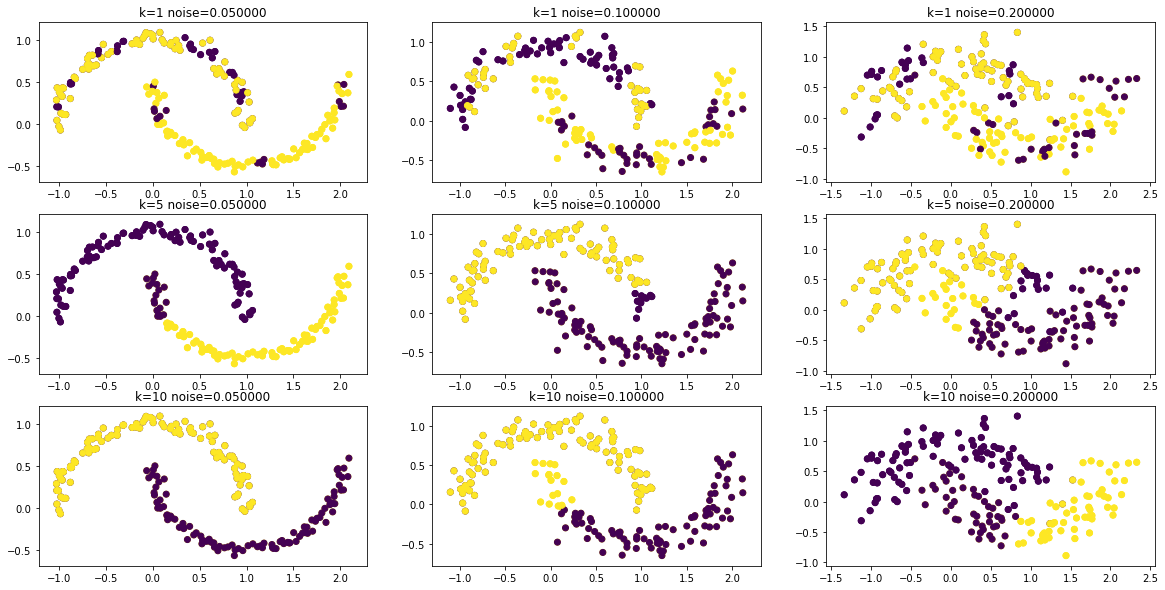

In [10]:
def transform2adj(sparsemat):
    A = sparsemat.A
    l = ((A.T + A) > 0)
    return l*np.ones_like(A)
# plot 
plt.figure(figsize=(20, 10))
labellist = []
# k :different values of neighbors
# j : different noise levels
for k in range(K):
    levellist = []
    for j in range(1, N+1):
        moons = lis_noisy_moons[j-1]
        X = moons[0]
        y_true = moons[1]
        plt.subplot(K, N, k*N+j)
        plt.scatter(x=X[:,0], y=X[:,1], c=y_true)
        plt.title('k=%i'%lis_knn[k]+' noise=%f'%noise_level_list[j-1])
        # transform the sparse matrix to adjacent ones
        adj_mat_sym = transform2adj(knn_nearests[k][j-1])
        # get the labels
        labels = spectral_clustering(adj_mat_sym, n_clusters=2)
        levellist.append(labels.copy())
        #print(labels)

        # draw the graph
        plt.scatter(x=X[:,0], y=X[:,1], c=labels)
    labellist.append(levellist.copy())

### answer: 
We can observe that for each level of noise, the performance of clustering is affected by k. And here we choose k=1,5,10, in these three k, we get better performance of clustering by increasing k. And the data points close to the other cluster are easy to misclassify. So the choice of k is very important which cannot be too small or too large.

### Question 5 : Complete the code in the box below

### define the similarity of two clusters
The similarity matrix of cluster1 $T_{sub}$ and cluster2 $T_{complete}$ is defined as $S(T_{sub},T_{complete}) = \dfrac{<T_{sub}, T_{complete}>} {\sqrt{<T_{sub}, T_{complete}><T_{sub}, T_{complete}>}}$, calcultated on the subset of Tsub. (where we take the Tsub to represent the bootstrap set. )

In [11]:
# get the bootstrap set (randomly choose 80% samples)
import random
import math

def sampling_boot(dataset, prop=0.8):
    '''data set is a numpy array'''
    sample_num = dataset.shape[0]
    idx_lis = np.arange(sample_num)

    # get the boot idx
    random.shuffle(idx_lis)
    bootstrap_idx = np.sort(idx_lis[0:math.floor(sample_num*prop)])
    
    return bootstrap_idx

moons = lis_noisy_moons[-1]
print(type(moons))
bootstrap_idx = sampling_boot(moons[0])
len(bootstrap_idx), bootstrap_idx

<class 'tuple'>


(160, array([  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  25,  26,  27,  29,  30,  32,
         33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
         48,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  70,  72,  73,  74,  75,
         76,  77,  79,  80,  81,  82,  83,  84,  86,  87,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98, 100, 103, 104, 106, 107, 108,
        109, 110, 113, 115, 118, 119, 120, 121, 122, 125, 126, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 144,
        145, 146, 151, 152, 153, 154, 155, 157, 158, 159, 161, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 173, 175, 176, 177, 179, 180,
        181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
        196, 197, 198, 199]))

In [12]:
# from labels we generate the C(i,j) matrix .
# C(i,j) = 1 if i and j is in the same cluster
# C(i, j) = 0 if else
def cluster_mat(labels):
    length = len(labels)
    mat = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            if labels[i] == labels[j] and i != j:
                mat[i, j] = 1
    return mat

# test
l = np.array([1,2,3,1,2,3,0])
l2 = np.array([1]*7)
mat = cluster_mat(l)
mat2 = cluster_mat(l2)

print(mat, mat2)
print(np.sum(mat*mat2))

[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]] [[ 0.  1.  1.  1.  1.  1.  1.]
 [ 1.  0.  1.  1.  1.  1.  1.]
 [ 1.  1.  0.  1.  1.  1.  1.]
 [ 1.  1.  1.  0.  1.  1.  1.]
 [ 1.  1.  1.  1.  0.  1.  1.]
 [ 1.  1.  1.  1.  1.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  0.]]
6.0


In [13]:
# define the similarity 
def similarity(lab_boot, lab_all, boot_idx):
    n_sub = len(boot_idx)
    
    if n_sub != len(lab_boot):
        raise Exception("the bootstrap index dimension doesn't correspond to the labels of boot")
    
    # get the correspond bootstrap labels
    lab_sub = lab_all[boot_idx]
    # generate the matrix of sub index and boot index
    sub_mat = cluster_mat(lab_sub)
    boot_mat = cluster_mat(lab_boot)
    # calculate the simularity
    sim = np.sum(sub_mat * boot_mat) / np.sqrt(np.sum(np.square(sub_mat)) * np.sum(np.square(boot_mat)))
    
    return sim

# test
l = np.array([1,2,3,1,2,3,0])
l2 = np.array([1]*10)
similarity(l, l2, np.arange(0,7))


0.3779644730092272

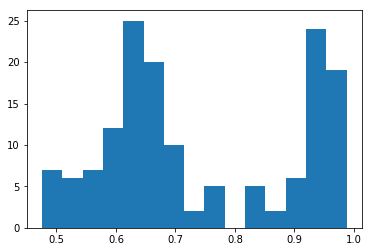

In [14]:
# calculate the clusters' similarity by running B times, 
# on the dataset of sparse matrix 
# generated by Knn, clustered in C clusters

def cluster_method_similarity(cluster_func, dataset, B, C):
    
    # transform the sparse matrix to adjacent ones
    adj_mat_sym = transform2adj(dataset)
    # run the cluster_func on the complete dataset for one time
    labels = cluster_func(adj_mat_sym, n_clusters=C)
    
    # run B times the clustering function and get the labels for
    # the boot set
    similarity_lis = []
    labels_boot_lis = []
    for b in range(B):
        # sampling
        boot_idx = sampling_boot(dataset)
        adj_mat_sym_boot = adj_mat_sym[boot_idx,:][ :, boot_idx]
        # get the labels list
        labels_boot = cluster_func(adj_mat_sym_boot, n_clusters=C)
        labels_boot_lis.append(labels_boot)
        # compare the boots labels with the complete samples' labels
        sim = similarity(boot_idx=boot_idx, lab_all=labels, lab_boot=labels_boot)
        similarity_lis.append(sim)
    
    return similarity_lis

# test
dataset = knn_nearests[-1][-1]
#print(type(knn_nearests[-1][-1]))
cluster_func = spectral_clustering
B = 150
C = 3
sims = cluster_method_similarity(cluster_func, dataset, B, C)

n, bins, patches = plt.hist(sims, bins=15)
plt.show()

#### We can conclude that the spectral algorithm is stable, since the distribution of similarity does concentrate at the maximum value of similarity, according to referrence [1].

### Question 6 : Complete the code in the box below

/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


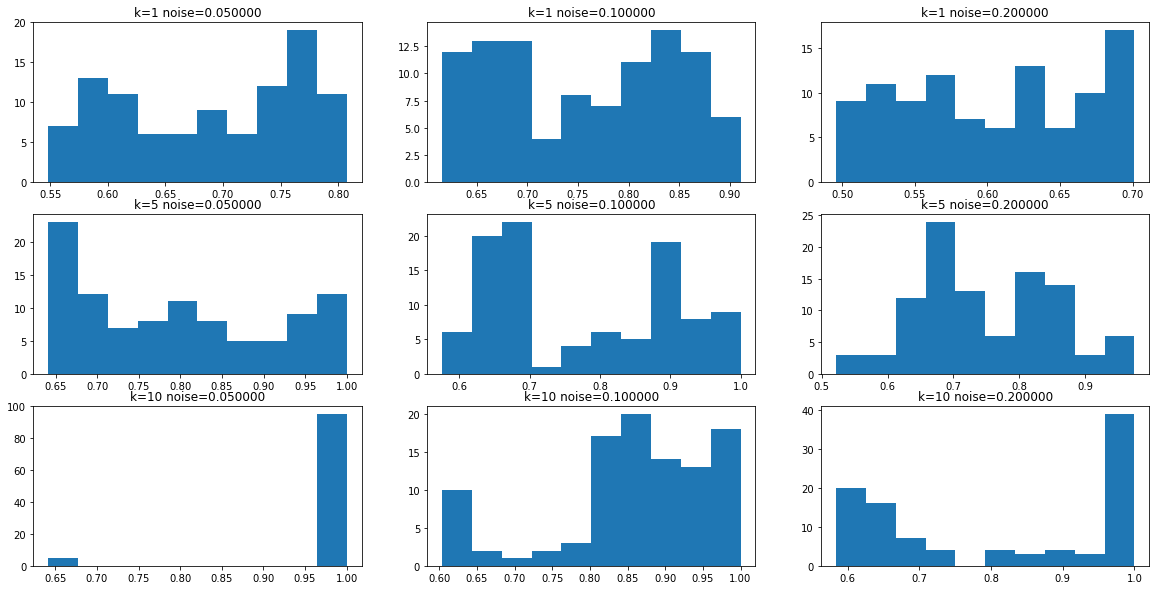

In [15]:
# given k = 5, we list different noise level

cluster_func = spectral_clustering
B = 100
C = 2

plt.figure(figsize=(20, 10))

for k, dataset_lis in enumerate(knn_nearests):
    for idx, dataset in enumerate(dataset_lis):
        sims = cluster_method_similarity(cluster_func, dataset, B, C)
        plt.subplot(K, N,idx+1+k*N)
        plt.title('k=%i'%lis_knn[k]+' noise=%f'%noise_level_list[idx])
        n, bins, patches = plt.hist(sims)


#### Given C=2, the stability criterion can help us to choose k. From the figure above, we saw that at different noise levels, the most stable k is different : at the lowest noise level, choose k = 10 gets the most stable result, at the highest level, choose k = 5 gets the most stable result.

### Question 7 : Complete the code in the box below

#### Hierarchical Clustering

In [16]:
from sklearn.cluster import AgglomerativeClustering

In [17]:
moons = lis_noisy_moons[-1]
X = moons[0]
# look at the labels, just try
ward = AgglomerativeClustering(n_clusters=2, linkage='average').fit(X)
label = ward.labels_
label

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

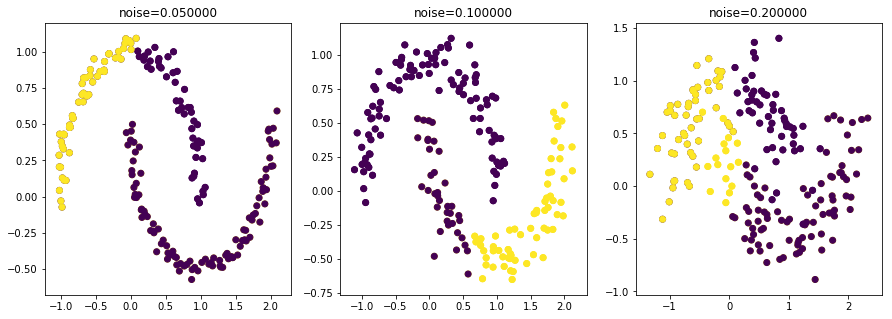

In [18]:
# HCA plot : 
def plot_HAC(method='ward', n_clusters=2):
    plt.figure(figsize=(15, 5))
    labellist = []
    # k :different values of neighbors
    # j : different noise levels
    for j in range(1, N+1):
        moons = lis_noisy_moons[j-1]
        X = moons[0]
        y_true = moons[1]
        plt.subplot(1, N, j)
        plt.scatter(x=X[:,0], y=X[:,1], c=y_true)
        plt.title('noise=%f'%noise_level_list[j-1])
        # get the labels
        labels = AgglomerativeClustering(n_clusters=n_clusters, linkage=method).fit(X).labels_

        # draw the graph
        plt.scatter(x=X[:,0], y=X[:,1], c=labels)
        
plot_HAC()

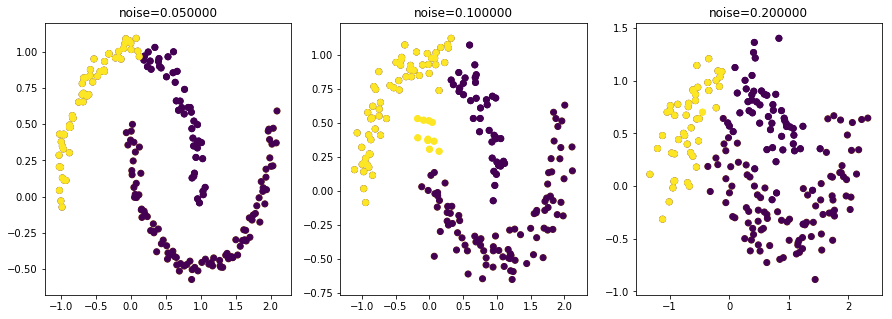

In [19]:
plot_HAC("average")

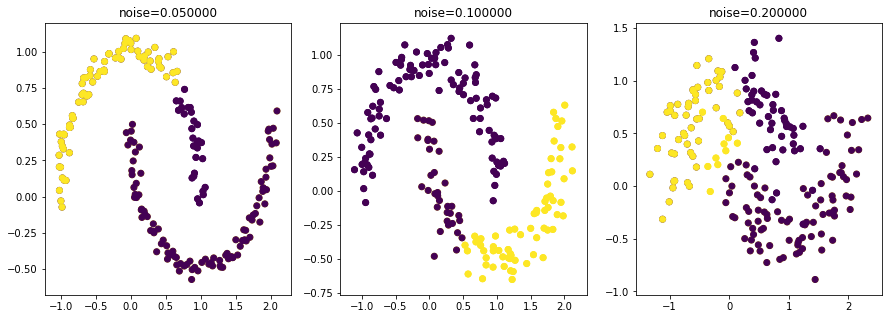

In [20]:
plot_HAC("complete")

#### Hierarchical Clustering stability

The 80 % percentile of similarity is : 0.582871545717
The 80 % percentile of similarity is : 0.581562507386
The 80 % percentile of similarity is : 0.581522928986


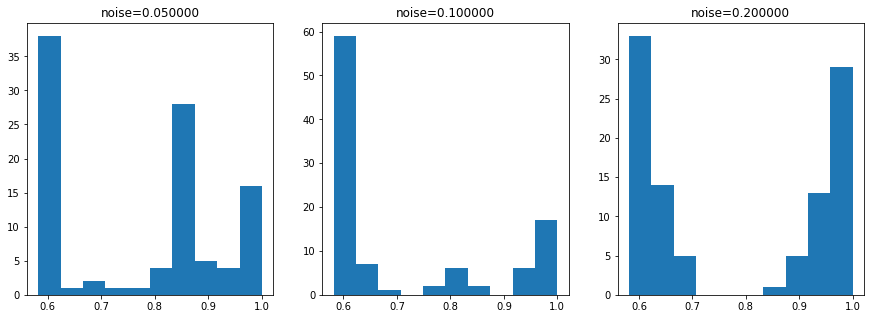

In [22]:
def HAC_method_similarity(linkage_method, dataset, B, C):

    # run the cluster_func on the complete dataset for one time
    labels = AgglomerativeClustering(linkage=linkage_method, n_clusters=C).fit(dataset).labels_
    
    # run B times the clustering function and get the labels for
    # the boot set
    similarity_lis = []
    labels_boot_lis = []
    for b in range(B):
        # sampling
        boot_idx = sampling_boot(dataset)
        # get the labels list
        labels_boot = AgglomerativeClustering(linkage=linkage_method, n_clusters=C).fit(dataset[boot_idx,:]).labels_
        labels_boot_lis.append(labels_boot)
        # compare the boots labels with the complete samples' labels
        sim = similarity(boot_idx=boot_idx, lab_all=np.array(labels), lab_boot=np.array(labels_boot))
        similarity_lis.append(sim)
    
    return similarity_lis

B = 100
C = 2

plt.figure(figsize=(15, 5))

for i in range(1, N+1):
    # take data out
    noisy_moons = lis_noisy_moons[i-1]
    X, y_true = noisy_moons[0], noisy_moons[1]
    sims = HAC_method_similarity("ward", X, B, C)
    print('The 80 % percentile of similarity is :', np.percentile(sims,0.8))
    plt.subplot(1, N, i)
    plt.title('noise=%f'%noise_level_list[i-1])
    n, bins, patches = plt.hist(sims)

#### From the graph above, we observe that  the distribution doesn't concentrate on the maximum value of similarity which doesn't show a strong stability distribution of similarity. And from the 80% precentile of similarity, we can check the unstability as well.

### Experiment on MNIST

### Get data

In [23]:
# Add your code here
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

#### check if well downloaded

In [24]:
%ls ~/scikit_learn_data/mldata/

mnist-original.mat


In [25]:
mnist, mnist.data.shape, mnist.target.shape, mnist.data[0]

({'COL_NAMES': ['label', 'data'],
  'DESCR': 'mldata.org dataset: mnist-original',
  'data': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ..., 
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])},
 (70000, 784),
 (70000,),
 array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        

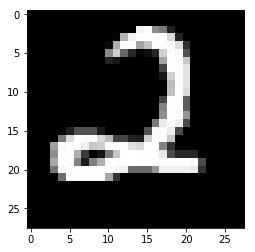

(15118, 2.0)

In [26]:
# an example of mnist

oid = random.randint(0, 69999)

first_image = np.array(mnist.data[oid], dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
oid, mnist.target[oid]

In [27]:
import time

#### check spectral clustering and compare it with eigengap algo.


In [32]:
# knn, try 500 samples, k=6
k = 3
idx_sampling = sampling_boot(dataset=mnist.data, prop=0.01)
X, y_true = mnist.data[idx_sampling], mnist.target[idx_sampling]
ts = time.time()
knn_adj_mat = kneighbors_graph(X, n_neighbors=k, n_jobs=6)
time.time() - ts

0.3229398727416992

### eigengap 

In [34]:
# transform to get the normalized Laplasian
adj_mat_mnist = transform2adj(knn_adj_mat)
W = adj_mat_mnist.copy()
D = np.diag(np.sum(W, axis=1))
L = D - W
L_normalized = (D**0.5).dot(L).dot(D**0.5)

In [42]:
# get the eigen weights and the eigen vectors
eigenW, eigenV = np.linalg.eig(L_normalized)

largest difference is  [ 45.05281711  12.71294787   8.38296659   3.39875878   3.20494568]
index is  [698 695 690 666 669]


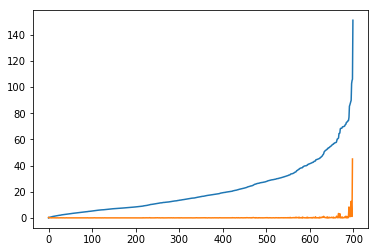

In [68]:
# draw eigen weights from small to larger one
sorted_eigenW = np.sort(eigenW)
plt.plot(sorted_eigenW)
# the 1-d difference
dif_sorted = [sorted_eigenW[i] - sorted_eigenW[i-1] for i in range(1, len(sorted_eigenW))]
plt.plot(dif_sorted)
# get the largest 10 
print("largest difference is ", np.sort(dif_sorted)[-5:][::-1])
print("index is ", np.argsort(dif_sorted)[-5:][::-1])

### which shows that the index i = 698 is the division index, thus we keep i= 699~ len(eigenW)

### We conclude that eigengap one is the best in terms of the computing time.

### spectral_clustering

In [238]:
# get labels
ts = time.time()
labels = spectral_clustering(adj_mat_mnist, n_clusters=10)
time.time() - ts

39.56949496269226

In [240]:
similarity(boot_idx=np.arange(len(y_true)),lab_all=y_true, lab_boot=labels)

0.4087817466487369

#### we saw that spectral_clustering for a 500 * 500 dimension matrix used 30s, which is intolerant !

### If we implement some preprocessing methods like the PCA ?

In [290]:
idx_sampling = sampling_boot(dataset=[mnist.data, mnist.target], prop=0.1)
X, y_true = mnist.data[idx_sampling], mnist.target[idx_sampling]

from sklearn import preprocessing
X = preprocessing.scale(X)


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [291]:
y_true, len(y_true)

(array([ 0.,  0.,  0., ...,  9.,  9.,  9.]), 7000)

In [292]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [293]:
X_reduc = pca.fit_transform(X)
X_reduc.shape

(7000, 4)

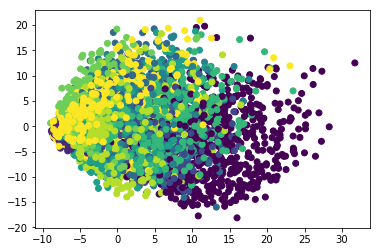

In [294]:
plt.scatter(X_reduc[:, 0], X_reduc[:, 1], c=y_true)

In [296]:
k = 5
ts = time.time()
knn_adj_mat = kneighbors_graph(X_reduc, n_neighbors=k, mode="connectivity", n_jobs=6)
# transform
adj_mat_mnist = transform2adj(knn_adj_mat)
time.time() - ts

2.929064989089966

In [297]:
ts = time.time()
# get labels
labels = spectral_clustering(adj_mat_mnist, n_clusters=10)
time.time() - ts

22.882317066192627

In [298]:
similarity(boot_idx=np.arange(len(y_true)),lab_all=y_true, lab_boot=labels)

0.32282784543903653

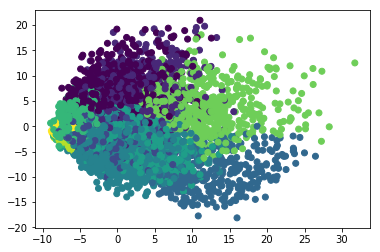

In [299]:
plt.scatter(X_reduc[:, 0], X_reduc[:, 1], c=labels)

#### study the relationship between k and C

In [289]:
# do a cycle to find the best k
for k in range(2, 10):
    for C in range(1, 11):
        ts = time.time()
        knn_adj_mat = kneighbors_graph(X_reduc, n_neighbors=k, mode="connectivity", n_jobs=6)
        # transform
        adj_mat_mnist = transform2adj(knn_adj_mat)
        print("create adjacent matrix using:",time.time() - ts, "seconds")
        ts = time.time()
        # get labels
        labels = spectral_clustering(adj_mat_mnist, n_clusters=C)
        print("doing spectral clustering using:", time.time() - ts, "seconds")
        sim = similarity(boot_idx=np.arange(len(y_true)),lab_all=y_true, lab_boot=labels)
        print("k=", k, "C=", C, "similarity between the original labels and the predicted clustering is ", sim)


create adjacent matrix using: 4.510812282562256 seconds


/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


doing spectral clustering using: 174.4871542453766 seconds
k= 2 similarity between the original labels and the predicted clustering is  0.378987176393
create adjacent matrix using: 2.3174471855163574 seconds
doing spectral clustering using: 27.91883611679077 seconds
k= 3 similarity between the original labels and the predicted clustering is  0.350457939524
create adjacent matrix using: 2.047168016433716 seconds
doing spectral clustering using: 21.687019109725952 seconds
k= 4 similarity between the original labels and the predicted clustering is  0.349857992604
create adjacent matrix using: 2.0435032844543457 seconds
doing spectral clustering using: 19.454580068588257 seconds
k= 5 similarity between the original labels and the predicted clustering is  0.33677534846
create adjacent matrix using: 2.8932390213012695 seconds
doing spectral clustering using: 23.379399061203003 seconds
k= 6 similarity between the original labels and the predicted clustering is  0.340056154767
create adjacent 

## Semi-Supervised Learning

Choice of the dataset used : **Precise** which dataset you chose and why it is relevant for the semi-supervised learning Task

Advised datasets :

*Breast Cancer Wisconsin (Diagnostic) Database*

*MNIST binary even vs odd (multiple clusters inside each class)*

Feel free to use other datasets if they are relevant

In [73]:
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split


### For all the next questions, use Cancer and Mnist classes to handle your data if you choose to use these one,
### You can also add more datasets but we advise you to handle them with this class for better readability
class semi_sup_dat:
    def __init__(self,data,p_unlabelled,name):
        # DON T CHANGE THE RANDOM STATES
        self.name = name
        if self.name == 'Mnist':
            # do an even vs odd binary classification :
            even = [0,2,4,6,8]
            Y = [int(y in even) for y in data.target]
        else:
            Y = data.target
        X_lab, X_unlab, y_lab, y_unlab = train_test_split(data.data, data.target, test_size=p_unlabelled, random_state=32)
        self.X_lab = X_lab
        self.X_unlab = X_unlab
        self.y_lab = y_lab
        self.y_unlab = y_unlab


# The following lines can be called later in the code to build a dataset with varying unlabelled proportion
p_unlabelled = 0.8 # You can change this value
Cancer = semi_sup_dat(load_breast_cancer(), p_unlabelled,'Cancer')
digits = load_digits()

Mnist = semi_sup_dat(load_digits(), p_unlabelled,'Mnist')

In [74]:
Mnist.X_lab.shape, Mnist.X_unlab.shape, Mnist.y_lab.shape, Mnist.y_unlab.shape, digits.data.shape

((359, 64), (1438, 64), (359,), (1438,), (1797, 64))

### Question 9 : Complete the code in the box below

#### implement the KNN with the moon dataset

In [75]:
#  Question 9  : Complete the function self_training
from sklearn.neighbors import KNeighborsClassifier

# step 1 fit the labeled data 
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(moons[0][0:20], moons[1][0:20])
moons[0].shape

(1000, 2)

In [76]:
# step 2 get the prediction for X_unlabel and the prob for each unlabeled prediction
prediction = neigh.predict(moons[0][20:])
prediction_prob = neigh.predict_proba(moons[0][20:])

In [77]:
prediction.shape, prediction_prob.shape, np.max(prediction_prob, axis=1).shape

((980,), (980, 2), (980,))

(array([ 137.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  843.]),
 array([ 0.66666667,  0.7       ,  0.73333333,  0.76666667,  0.8       ,
         0.83333333,  0.86666667,  0.9       ,  0.93333333,  0.96666667,  1.        ]),
 <a list of 10 Patch objects>)

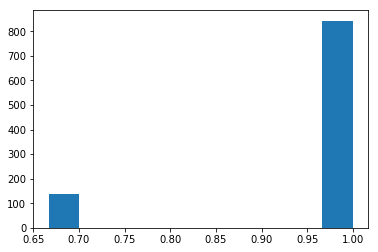

In [78]:
plt.hist(np.max(prediction_prob, axis=1))

In [79]:
# get a 95 percentile for the prediction probability
p = np.percentile(np.max(prediction_prob, axis=1), 95) 
p

1.0

In [80]:
# step 3 find the confident unlabeled samples and add to labeled ones
conf_idx = np.max(prediction_prob, axis=1) >= p
len(conf_idx)

old_samples = moons[0][0:20]
conf_samples = moons[0][20:][conf_idx]
conf_samples.shape, old_samples.shape
new_samples = np.vstack((old_samples, conf_samples))
new_y = np.concatenate([moons[1][0:20], prediction[conf_idx]])
left_unlabels = moons[0][20:][~conf_idx]
len(left_unlabels) + len(new_samples)

1000

In [81]:
l = np.array([2,3,4]) > 3
print(l)
print(sum(~l))
sum(~(np.array([2,3,4]) > 3))

[False False  True]
2


2

#### Define the function and try with the data of Mnist

In [82]:
def split_unlabel_set(p_test, x, y):
    X_lab, X_test, y_lab, y_test = train_test_split(x, y, test_size=p_test, random_state=32)
    return X_lab, X_test, y_lab, y_test

def self_training(X_lab_orig, y_lab_orig, X_unlab_orig, X_test, y_test, n_neighbors=3, percent=0.95, delta=1000, tol=1e-4, maxstep=100):
    # do the copy
    X_lab = X_lab_orig.copy()
    X_unlab = X_unlab_orig.copy()
    y_lab = y_lab_orig.copy()
    sim, k = delta, 0
    # step 1 fit the labeled data 
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(X_lab, y_lab)
    
    while k < maxstep and X_unlab.shape[0] > 0:
        prediction_test = neigh.predict(X_test)

        # step 2 get the prediction for X_unlabel and the prob for each unlabeled prediction
        prediction = neigh.predict(X_unlab)
        prediction_prob = neigh.predict_proba(X_unlab)
        # get the p_percentile
        #p = np.percentile(np.max(prediction_prob, axis=1), percent)
        # step 3 find the confident unlabeled samples and add to labeled ones
        conf_idx = np.max(prediction_prob, axis=1) >= percent
        #plt.hist(np.max(prediction_prob, axis=1))
        
        # step 4 update the labeled data and unlabeled data
        new_labeled = np.vstack((X_lab, X_unlab[conf_idx]))
        new_y = np.concatenate([y_lab, prediction[conf_idx]])
        new_unlabeled = X_unlab[~conf_idx]
        #print(new_unlabeled.shape[0])
        
        X_lab, X_unlab, y_lab = new_labeled, new_unlabeled, new_y
        
        # step 5 use the neigh algo on the updated dataset and calculate the similarity
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
        neigh.fit(X_lab, y_lab)
        
        prediction_new_test = neigh.predict(X_test)
        
        sim = similarity(boot_idx=np.arange(len(y_test)), lab_all=prediction_new_test, lab_boot=prediction_test)
        print("k = ", k, ", updated classifier on the test set, sim = ", sim, ", X_unlab samples =", X_unlab.shape[0] )
        
        # step 6 update neigh classifer and k 
        k += 1
        
        if 1-sim < tol :
            break
        
    return neigh, sim

p_test = 0.5
p_unlabelled = 0.7
Mnist = semi_sup_dat(load_digits(), p_unlabelled,'Mnist')

X_lab, X_test, y_lab, y_test = split_unlabel_set(p_test, Mnist.X_lab, Mnist.y_lab)
myneigh, sim = self_training(X_lab_orig=X_lab, y_lab_orig=y_lab, X_unlab_orig=Mnist.X_unlab, X_test=X_test, y_test=y_test)
print(sim)

k =  0 , updated classifier on the test set, sim =  0.963224326958 , X_unlab samples = 164
k =  1 , updated classifier on the test set, sim =  0.994154115389 , X_unlab samples = 51
k =  2 , updated classifier on the test set, sim =  1.0 , X_unlab samples = 31
1.0


In [83]:
pred = myneigh.predict(X_test)
similarity(boot_idx=np.arange(len(y_test)), lab_all=y_test, lab_boot=pred)

0.97104270259890502

prediction : 
 [0 8 5 5 6 1 0 8 8 8 2 6 2 1 5 0 1 9 7 3] 
real labels: 
 [0 8 5 5 6 8 0 8 8 8 2 6 2 1 5 0 1 9 7 3]


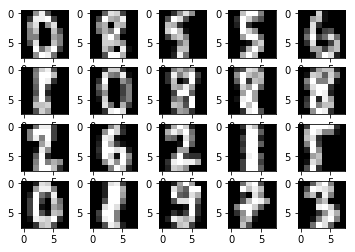

In [84]:
examples = 20
for i in range(examples):
    plt.subplot(4, 5, i+1)
    pixels = X_test[i].reshape((8, 8))
    plt.imshow(pixels, cmap='gray')
print("prediction : \n",myneigh.predict(X_test[0:examples]),"\nreal labels: \n", y_test[0:examples])

### Remark: For the Mnist set, we got a similarity > 0.92 on the test set, which is not bad.

In [85]:
p_test = 0.5
p_unlabelled = 0.8
Cancer = semi_sup_dat(load_breast_cancer(), p_unlabelled,'Cancer')

X_lab, X_test, y_lab, y_test = split_unlabel_set(p_test, Cancer.X_lab, Cancer.y_lab)
myneigh, sim = self_training(X_lab_orig=X_lab, y_lab_orig=y_lab, X_unlab_orig=Cancer.X_unlab, X_test=X_test, y_test=y_test)
print(sim)

k =  0 , updated classifier on the test set, sim =  0.969132364304 , X_unlab samples = 69
k =  1 , updated classifier on the test set, sim =  1.0 , X_unlab samples = 23
1.0


### Remark: For the Cancer set, we got a similarity > 0.96, which is good.

#### we now turned to the hyperparametres

### Question 10 : Complete the code in the box below

### The code and results of Self-training algo. are already done in Question 9, please refer to them in the above.

###### Closed form expression :

- $\alpha^{*},b^{*}=\mathop{\arg\min}_{b,\alpha \in \mathbb{R^{u+l}}}\dfrac{1}{l}(Y-J(K\alpha+\mathbb{1}b))^{T}(Y-J(K\alpha-\mathbb{1}b))+\lambda[\alpha^{T}K\alpha]+\dfrac{\lambda_{u}}{(u+l)^{2}}[\alpha^{T}K^{T}LK\alpha]$

- To get the optimal $\alpha$, we can take a derivative w.r.t it, we can get

$\dfrac{1}{l}(-JK)^{T}(Y-J(K\alpha+\mathbb{1}b))+(\lambda K+\dfrac{\lambda_{u}l}{(u+l)^{2}}K^{T}LK)\alpha=0$

- To get the optimal b, we can take a derivative w.r.t it, we can get 

$\dfrac{1}{l}(-J\mathbb{1})^{T}(Y-J(K\alpha+\mathbb{1}b))=0$

where K is the (l + u) × (l + u) Gram matrix over labeled and unlabeled points; Y is an (l + u)
dimensional label vector given by: $Y = [y_{1},..., y_{l}
,0,...,0]$ and J is an (l + u) × (l + u) diagonal
matrix given by J = diag(1,...,1,0,...,0) with the first l diagonal entries as 1 and the rest 0.

- Finally we can get $b^{*}=\dfrac{1}{l}(\mathbb{1}^{T}JY-\mathbb{1}^{T}JK\alpha)$ and $\alpha^{*}=(JK+\lambda lI+\dfrac{\lambda_{u}l}{(u+l)^{2}}LK-\dfrac{1}{l}J\mathbb{1}\mathbb{1}^{T}JK)^{-1}(Y-\dfrac{1}{l}J\mathbb{1}\mathbb{1}^{T}JY)$


### Question 11 : Complete the code in the box below

### Implement the LapRLS

In [86]:
from sklearn.metrics.pairwise import rbf_kernel # Or reimplement it yourself if your prefer
from scipy.linalg import block_diag

In [87]:
def get_dataset(datasetsX, datasetsY, p_unlabel):
    X_lab, X_unlab, y_lab, y_unlab = split_unlabel_set(p_unlabel, datasetsX, datasetsY)
    
    return X_lab, X_unlab, y_lab, y_unlab

1.0 1.0


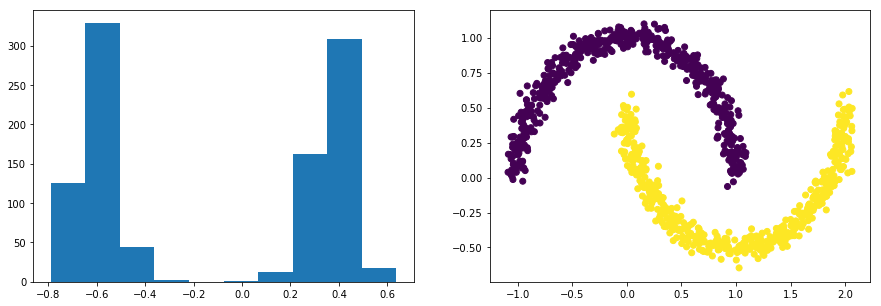

In [145]:
def LapRLS(X_lab_orig, X_unlab_orig, y_lab_orig, y_unlab_orig, lamb=1e-4, lamb_u=1e-2):
    # do the copy
    X_lab = X_lab_orig.copy()
    X_unlab = X_unlab_orig.copy()
    y_lab = y_lab_orig.copy()
    y_unlab = y_unlab_orig.copy()
    
    train_X = np.vstack((X_lab, X_unlab))
    train_y = np.concatenate([y_lab, len(y_unlab)*[0]])
    
    W = rbf_kernel(train_X)
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    
    K = rbf_kernel(X=train_X)
    
    l, u = len(X_lab), len(X_unlab)
    #lamb = 5/(l+u)
    #lamb_u = 5/(l+u)
    J = np.diag([1]*l + [0]*u)
    I = np.diag([1]*(l+u))
    ones = np.ones((l+u, l+u))
    temp = J.dot(ones).dot(J)
    Y = train_y
    
    alpha = np.linalg.inv(J.dot(K) + lamb*l*I + lamb_u*l/(u + l)**2 * L.dot(K) - 1/l*temp.dot(K)).dot(I - 1/l*temp).dot(Y)
    f_output = K.dot(alpha)
    #b = 1/l*np.sum(-f_output[:l] + Y[:l])
    #f_output = f_output 
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.hist(f_output)
    #print(f_output[l:])
    
    f_output = f_output > 0
    
    plt.subplot(1,2,2)
    plt.scatter(x=train_X[:, 0], y=train_X[:, 1], c=f_output)
    
    
    accu_lab = 1 - sum(np.abs(f_output[:l] - Y[:l]))/len(f_output[:l])
    accu = 1 - sum(np.abs(f_output[l:] - y_unlab))/len(f_output[l:])
    print(accu, accu_lab)
    
    return f_output, accu, accu_lab, alpha, train_X

p_unlabel = 0.8
moons = make_moons(n_samples=1000, noise=0.05)
X_lab, X_unlab, y_lab, y_unlab = get_dataset(moons[0], moons[1], p_unlabel)
f_output, _, _, alpha, train_X = LapRLS(X_lab, X_unlab, y_lab, y_unlab)
#plt.scatter(x=train_X[:, 0], y=train_X[:, 1], c=f_output)

### the predict function

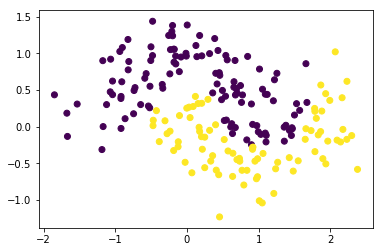

In [146]:
# write a function for predicting, using train set X and alpha returned above
def LapRLS_predict(train_X, new_X, alpha):
    K = rbf_kernel(X=train_X, Y=new_X)
    #print(K.shape, alpha.shape)
    predict = np.dot(K.T, alpha)
    #print(K.T, alpha.T, predict)
    lag = np.array(list(map(lambda x:-1 if x < 0 else 1, predict)))
    
    return lag

new_X, new_y = make_moons(n_samples=200,noise=0.3)
testlags = LapRLS_predict(train_X, new_X, alpha)
plt.scatter(x=new_X[:, 0], y=new_X[:, 1], c=testlags)


### fix $\lambda = 1e-5$, and try different values of $\lambda u$

0.99875 1.0


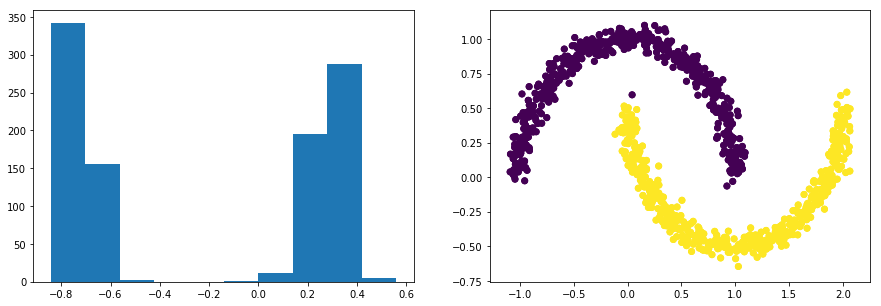

In [147]:
f_output = LapRLS(X_lab, X_unlab, y_lab, y_unlab, lamb=1e-5, lamb_u=1e-3)[0]
train_X = np.vstack((X_lab, X_unlab))
plt.scatter(x=train_X[:, 0], y=train_X[:, 1], c=f_output)

In [159]:
# train set
moons = make_moons(n_samples=800, noise=0.05)
X_lab, X_unlab, y_lab, y_unlab = get_dataset(moons[0], moons[1], p_unlabel=0.8)
# test set
X_test, y_test = make_moons(n_samples=300, noise=0.05)
y_test = np.array(list(map(lambda x:-1 if x < 0 else 1, y_test.copy())))

lambda_u =  1e-06
0.978125 0.96875
lambda_u =  1e-05
0.978125 0.96875
lambda_u =  0.0001
0.978125 0.96875
lambda_u =  0.001
0.978125 0.96875
lambda_u =  0.01
0.978125 0.96875
lambda_u =  0.1
0.978125 0.96875
lambda_u =  1.0
0.978125 0.96875
lambda_u =  10.0
0.984375 0.975
lambda_u =  100.0
0.9890625 0.975
lambda_u =  1000.0
0.9875 0.9875
lambda_u =  10000.0
0.834375 0.775
lambda_u =  100000.0
0.4953125 0.5875
lambda_u =  1000000.0
0.4859375 0.55625


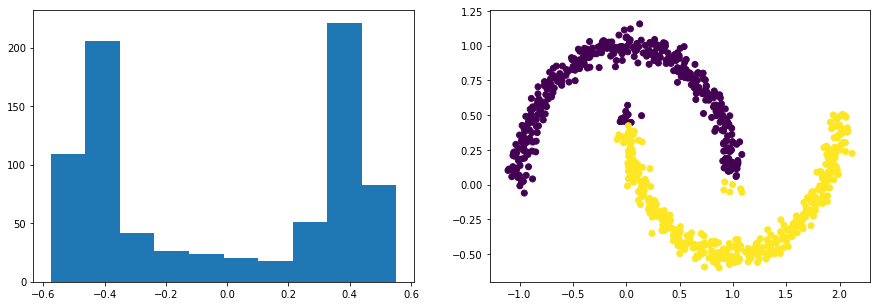

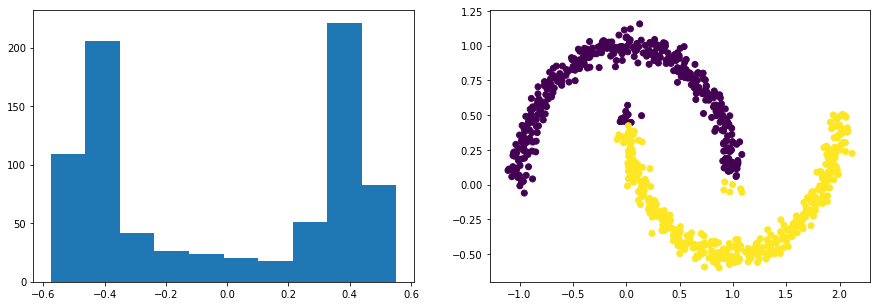

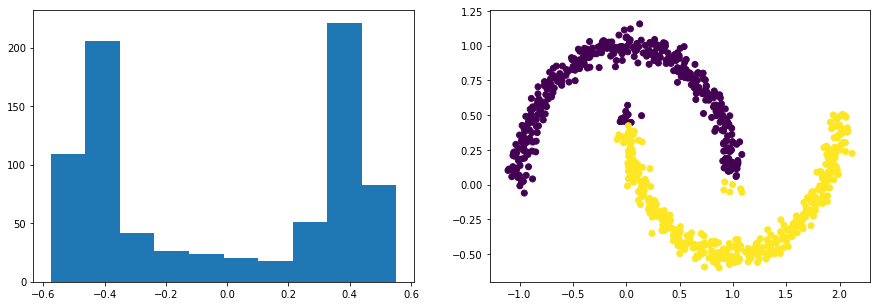

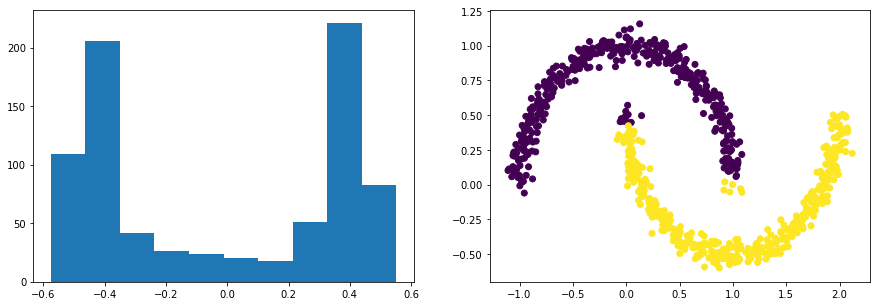

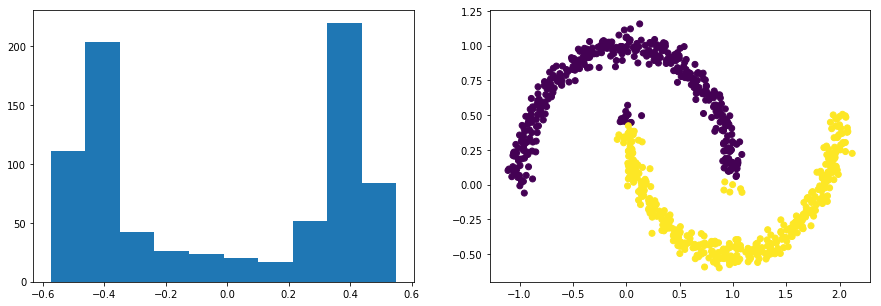

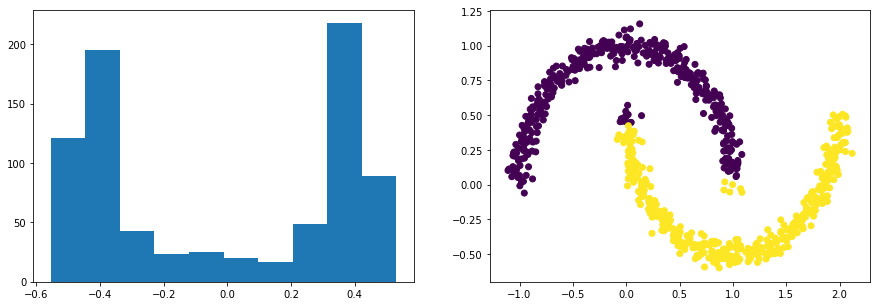

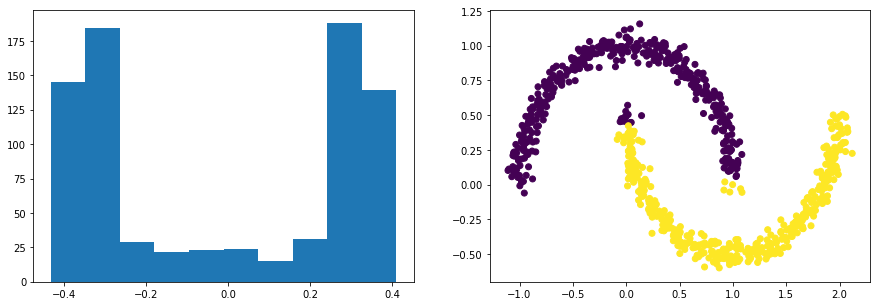

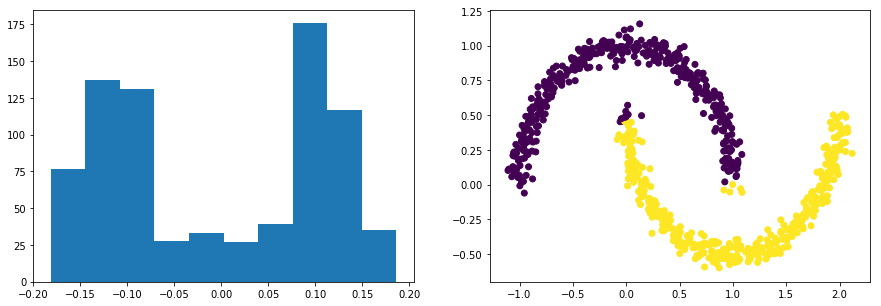

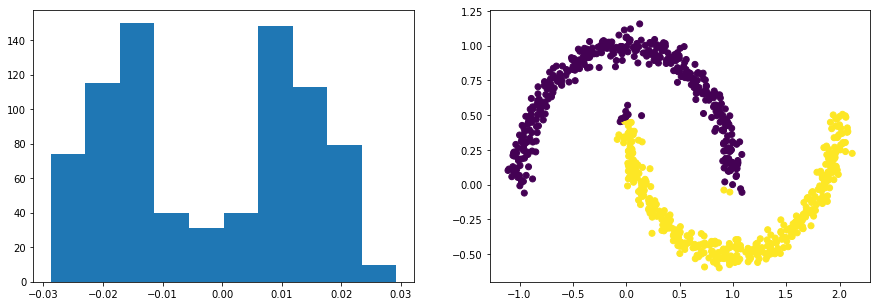

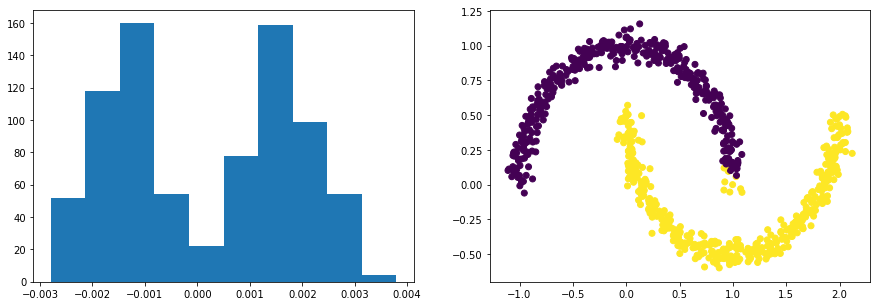

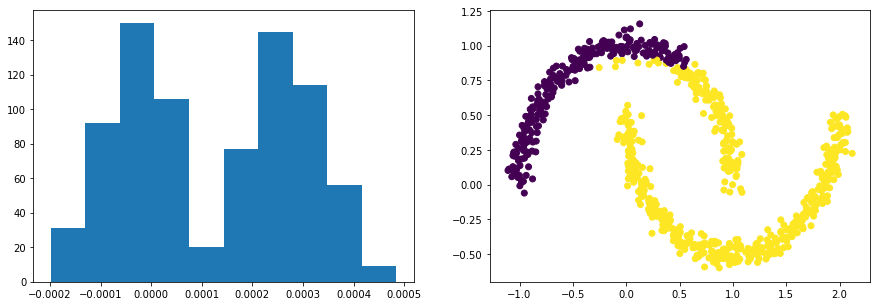

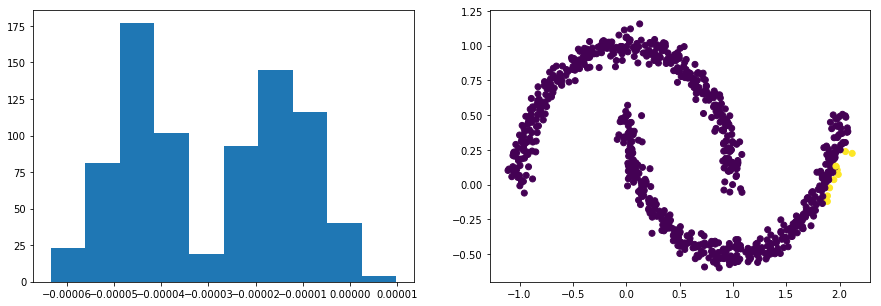

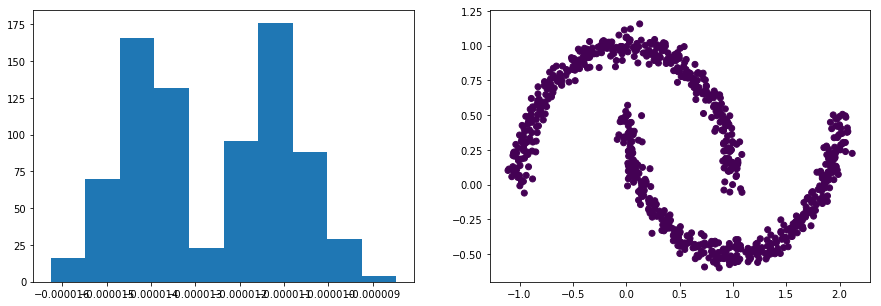

In [162]:
lamb = 1e-2
lamb_u_lis = 10**np.arange(1, 14)*1e-7
acc_lis = []
acc_lab_lis = []
#acc_test_lis = []
for lamb_u in lamb_u_lis:
    print("lambda_u = ", lamb_u)
    f_output, acc, acc_lab, alpha, train_X = LapRLS(X_lab, X_unlab, y_lab, y_unlab, lamb=lamb, lamb_u=lamb_u)
    # test
    #lags_moons = LapRLS_predict(alpha=alpha, new_X=X_test, train_X=train_X)
    #accu_test = sum(np.abs(lags_moons - y_test == 0))/len(lags_moons)
    #print("accuracy on test =", accu_test)
    #acc_test_lis.append(accu_test)
    acc_lis.append(acc)
    acc_lab_lis.append(acc_lab)


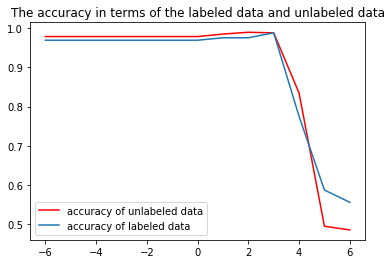

In [163]:
plt.plot(np.log10(lamb_u_lis), acc_lis, c='red', label='accuracy of unlabeled data')
plt.plot(np.log10(lamb_u_lis), acc_lab_lis, label='accuracy of labeled data')
#plt.plot(np.log10(lamb_u_lis), acc_test_lis, c='green', label='accuracy on the test set')
plt.title('The accuracy in terms of the labeled data and unlabeled data')
plt.legend()

### test LapRLS on real data 

0.928571428571 1.0
accuracy on the test set is 0.833333333333


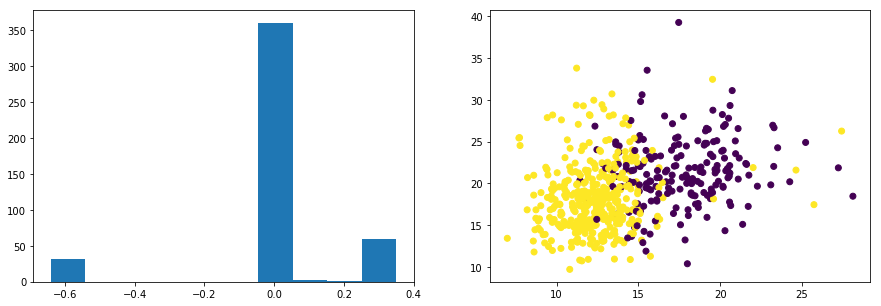

In [165]:
#p_test = 0.8
p_unlabelled = 0.2
Cancer = semi_sup_dat(load_breast_cancer(), p_unlabelled,'Cancer')
# our train data:
X_lab, X_unlab, y_lab, y_unlab = split_unlabel_set(p_test, Cancer.X_lab, Cancer.y_lab)
f_output, acc, acc_lab, alpha, train_X = LapRLS(X_lab, X_unlab, y_lab, y_unlab, lamb=1e-4, lamb_u=1e-3)

# test on Cancer.unlab
lags_cancer = LapRLS_predict(alpha=alpha, new_X=Cancer.X_unlab, train_X=train_X)
lags_cancer = list(map(lambda x: 0 if x==-1 else 1, lags_cancer))
accu = 1 - sum(np.abs(lags_cancer - Cancer.y_unlab))/len(lags_cancer)
print("accuracy on the test set is", accu)
plt.scatter(x=Cancer.X_unlab[:, 0], y=Cancer.X_unlab[:, 1], c=lags_cancer)

### Question 12 : Add your answer here

- we observed that when $\lambda$ is fixed at a proper level, the accuracy of labeled and unlabeled data can be both quite good.

- with a $\lambda u$ too small, the accuracy of labeled ones increase much faster than unlabeled ones. and when $\lambda u$ too large, the unlabeled ones' accuracy drops much faster than labeled ones

### Question 13 : Complete the code in the box below


- The implementation of closed-form solution increases the cost of calculation of the algorithm (the multiplication and inversion of matrix ect.) which leads to the high complexity. This may be impractical for large data sets. But this is much more efficient when the data is low-dimensional.

### Question 14 : Complete the code in the box below

##### Add your answer to the question here :

- We can rewrite our problem in the form of separable function as follows in order to solve it with LapRLS using the stocahstic gradient descent algorithm:
$$
\mathop{min}_{f\in H_{k}}\dfrac{1}{u+l}\sum_{i=1}^{u+l}(\dfrac{u+l}{l}(Y_{i}-J(K_{i}^{T}\alpha+b))^2+\lambda\alpha^{T}K\alpha+\dfrac{\lambda_{u}}{(u+l)^2}\alpha^{T}KLK\alpha)
$$
Here $K_{i}$ is the $i^{th}$ column of K where K is the (l + u) × (l + u) Gram matrix over labeled and unlabeled points; Y is an (l + u) dimensional label vector given by:$ Y = [y_{1},..., y_{l},0,...,0]$ and J is an (l + u) × (l + u) diagonal matrix given by J = diag(1,...,1,0,...,0) with the first l diagonal entries as 1 and the rest 0. And according to the property of the algorithm of SGD: 
$$
\nabla f_{i}(\alpha)=\begin{cases}2\dfrac{u+l}{l}K_{i}(K_{i}^T\alpha+b-Y_{i})+2(\lambda K+\dfrac{\lambda_{u}}{(u+l)^{2}}K^{T}LK)\alpha,\quad 1\leq i\leq l\\
2(\lambda K+\dfrac{\lambda_{u}}{(u+l)^{2}}K^{T}LK)\alpha,\quad l+1\leq i \leq u+l
\end{cases}
$$
$$
\nabla f_{i}(b)=\begin{cases}2\dfrac{u+l}{l}(K_{i}^T\alpha+b-Y_{i}),\quad 1\leq i\leq l\\
0,\quad l+1\leq i \leq u+l
\end{cases}
$$

We can update $\alpha$ and b using stochastic gradient descent algorithm:
$$
\alpha_{new}=\alpha_{old}-step*\nabla f_{i}(\alpha_{old})\\
b_{new} = b_{old}-step*\nabla f_{i}(b_{old})
$$

In [166]:
#LapRLS using the stocahstic gradient descent algorithm
def LapRLS_SGD(lab_X_, lab_y_, unlab_x_, unlab_y_, lambda_1, lambda_u_,n_iter,step):
    X = np.vstack((lab_X_,unlab_x_))
    l = len(lab_y_)
    u = unlab_x_.shape[0]
    K = rbf_kernel(X)
    D = np.diag(np.sum(K,axis=1))
    L = D-K
    alpha_ = np.zeros(u+l)
    b_ = 0
    Y = np.concatenate([lab_y_,np.zeros(u)])
    D = np.diag(np.sum(K,axis=1))
    J = np.diag([1]*l+[0]*u)
    iis = np.random.randint(0, u+l, n_iter*(u+l)) 
    for idx in range(n_iter*(u+l)):
        i = iis[idx]
        k_ = K[i,:]
        y_ = Y[i]
        if(i<l):
            grad_i_alpha = 2*(l+u)/l*(k_.dot(-y_+k_.dot(alpha_)+b_))+2*(lambda_1*K+((lambda_u_)/(u+l)**2)*K.dot(L.dot(K))).dot(alpha_)
            grad_i_b = 2*(l+u)/l*(b_-y_+k_.dot(alpha_)) 
        else:
            grad_i_alpha = 2*(lambda_1*K+((lambda_u_)/(u+l)**2)*K.dot(L.dot(K))).dot(alpha_)
            grad_i_b = 0
        alpha_ -= step*grad_i_alpha
        b_ -= step*grad_i_b
    
    f_output = K.dot(alpha_)
    plt.hist(f_output)
    f_output = f_output>0
    accu = 1 - sum(np.abs(f_output[l:] - unlab_y_))/len(f_output[l:])
    accu_lab = 1 - sum(np.abs(f_output[:l] - lab_y_))/len(f_output[:l])
    return f_output, accu, accu_lab       

In [ ]:
# test
X_, y_ = make_moons(n_samples=500,noise=0.05)
X_tr, X_te, y_tr, y_te = train_test_split(X_,y_,test_size=0.6,random_state=32)
a,b,c=LapRLS_SGD(X_tr, y_tr, X_te, y_te, 0.01, 0.1,5,1e-3)

In [169]:
print('the accuray of unlabeled data: %f'%b)
print('the accuracy of labeled data: %f'%c)

the accuray of unlabeled data: 0.501250
the accuracy of labeled data: 0.495000


#### fix the value of $\lambda$ and play with $\lambda_{u}$ 

lambda_u =  0.01
lambda_u =  0.1
lambda_u =  1.0
lambda_u =  10.0
lambda_u =  100.0


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: overflow encountered in multiply
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in subtract


ValueError: max must be larger than min in range parameter.

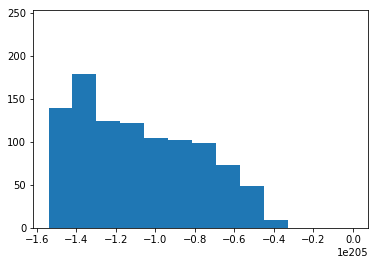

In [188]:
### play with the hyperparameters and plot the errors
lamb = 0.01
lamb_u_lis = 10**np.arange(5, 10)*1e-7
acc_lis = []
acc_lab_lis = []
for lamb_u in lamb_u_lis:
    print("lambda_u = ", lamb_u)
    f_output, acc, acc_lab = LapRLS_SGD(X_lab, y_lab, X_unlab, y_unlab, lamb, lamb_u,5,1e-3)
    acc_lis.append(1-acc)
    acc_lab_lis.append(1-acc_lab)

plt.plot(np.log10(lamb_u_lis), acc_lis, c='red', label='errors of unlabeled data')
plt.plot(np.log10(lamb_u_lis), acc_lab_lis, label='errors of labeled data')
plt.title('The errors in terms of the labeled data and unlabeled data')
plt.legend()

### Question 15 : Complete the code in the box below

Now we work on LapSVM which minimises:
$$
\mathop{min}_{f\in H_{k}}\dfrac{1}{l}\sum_{i=1}^{l}(1-y_{i}f(x_{i}))_{+}+\lambda \|f\|^{2}_{H_{k}}+\dfrac{\lambda_{u}}{(u+l)^2}f^{T}Lf
$$
We can take derivative of the reduced Lagrangian with respect to $\alpha$ as we have seen from the reference[2] which implies:
$$
\alpha=(2\lambda I+2\dfrac{\lambda_{u}}{u+l}^{2}LK)^{-1}J^{T}Y\beta^{*}
$$
Note that the relationship between α and β is no longer as simple as the SVM algorithm. In
particular, the (l +u) expansion coefficients are obtained by solving a linear system involving the l
dual variables that will appear in the SVM dual problem.
Substituting back in the reduced Lagrangian we get:
$$
\beta^{*}=\mathop{max}_{\beta \in \mathbb{R}^{l}}\sum_{i=1}^{l}\beta_{i}-\dfrac{1}{2}\beta^{T}\beta\\
subject\ to:\sum_{i=1}^{l}\beta_{i}y_{i}=0,\quad 0\leq\beta_{i}\leq \dfrac{1}{l}\quad i=1...l\\
$$
where 
$$
Q=YJK(2\lambda I+2\dfrac{\lambda_{u}}{(u+l)^2}LK)^{-1}J^{T}Y
$$

### QP SVM

In [171]:
# use a svc solver -- standard with different kernel matrix 
from sklearn.svm import SVC, LinearSVC
LinearSVC??

[LibSVM]shape beta =  (1, 91)
label set # =  (91,)
0.857142857143 1.0


array([-1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1, -1,  1,
        1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
       -1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
       -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1,
       -1,  1,  1,  1, -1])

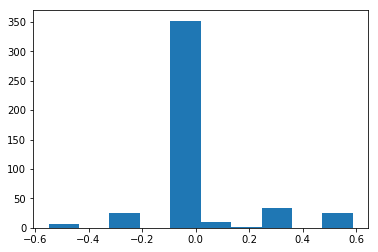

In [172]:
def LapSVM(X_lab, X_unlab, y_lab, y_unlab, lamb=1e-4, lamb_u=1e-2):
    
    train_X = np.vstack((X_lab, X_unlab))
    train_y = np.concatenate([y_lab, len(y_unlab)*[0]])
    
    Y = np.diag(y_lab)
    l, u = len(X_lab), len(X_unlab)

    J = np.diag([1]*l + [0]*u)[:l, :]
    I = np.diag([1]*(l+u))
    
    W = rbf_kernel(train_X)
    D = np.diag(np.sum(W, axis=1))
    L = D - W

    K = rbf_kernel(X=train_X)

    def call_Q(train_X, train_y):

        #ones = np.ones((l+u, l+u))
        #temp = J.dot(ones).dot(J)
        #temp = Y.dot(J).dot(K)
        temp = J.dot(K)
        inv = np.linalg.inv(2*lamb*I + 2*lamb_u/(u + l)**2 * L.dot(K))
        
        return temp.dot(inv).dot(J.T)

    clf = SVC(C=1/l, kernel=call_Q, verbose=True)
    clf.fit(train_X, train_y)
    
    beta = np.abs(clf.dual_coef_) # which gives the solution for dual problem ?
    inv = np.linalg.inv(2*lamb*I + 2*lamb_u/(u + l)**2*L.dot(K))
    alpha = inv.dot(J.T).dot(Y)
    print("shape beta = ", beta.shape)
    print("label set # = ", y_lab.shape)

    complete = alpha.shape[1] - beta.shape[1]
    if complete > 0 :
        zeros = np.zeros((1,complete))
        beta_new = np.zeros((1,alpha.shape[1]))
        print("shape of beta is ", beta.shape[1] )
        print("add zeros for the incomplete features, # = ", complete)
        #print(zeros.shape)
        #print(beta.shape)
        j = 0
        for i in clf.support_:
            beta_new[0,i] = beta[0, j]
            j += 1
        beta = beta_new
        #beta = np.concatenate([beta.T, zeros.T]).T
    
    #print(beta, y_lab)
    alpha = alpha.dot(beta.T)
    
    f_output = K.dot(alpha)
    #print(K.shape, alpha.shape)
    plt.hist(f_output)
    
    f_output = np.array(list(map(lambda x: 1 if x > 0 else -1, f_output)))
    
    accu_lab = 1 - np.sum(np.abs(f_output[:l].T - y_lab))/len(f_output[:l])
    accu = 1 - np.sum(np.abs(f_output[l:].T - y_unlab))/len(f_output[l:])
    print(accu, accu_lab)
    
    return f_output, accu, accu_lab, clf, alpha, train_X

# test by cancer set, note to change the label of y from {0,1} to {-1, 1}
p_test = 0.8
Cancer = semi_sup_dat(load_breast_cancer(), p_unlabelled,'Cancer')
Cancer.y_lab = np.array(list(map(lambda x:-1 if x == 0 else 1, Cancer.y_lab.copy())))
X_lab, X_unlab, y_lab, y_unlab = split_unlabel_set(p_test, Cancer.X_lab, Cancer.y_lab)
f_output, _, _, clf, alpha, train_X = LapSVM(X_lab, X_unlab, y_lab, y_unlab, lamb=0.01, lamb_u=1e-5) 


# write a function for predicting, using train set X and alpha returned above
def LapSVM_predict(train_X, new_X, alpha):
    K = rbf_kernel(X=train_X, Y=new_X)
    #print(K.shape, alpha.shape)
    predict = np.dot(K.T, alpha)
    #print(K.T, alpha.T, predict)
    lag = np.array(list(map(lambda x:-1 if x < 0 else 1, predict)))
    
    return lag

LapSVM_predict(train_X, train_X[0:90, :], alpha)

[LibSVM]shape beta =  (1, 8)
label set # =  (100,)
shape of beta is  8
add zeros for the incomplete features, # =  92
1.0 1.0


array([-1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1,
        1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,
        1,  1,  1, -1,  1, -1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1,
        1, -1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
        1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1,  1,  1,  1,  1,
       -1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1, -1,
       -1,  1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1,  1, -1,
        1,  1, -1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1, -1,
       -1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1, -1, -1, -1, -1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1,  1])

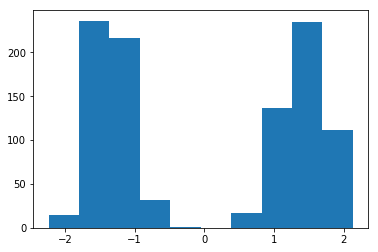

In [173]:
# the moons set , changed y label to 1 or -1
p_unlabel = 0.9
moons = make_moons(n_samples=1000, noise=0.05)
moons_y_lab = np.array(list(map(lambda x:-1 if x == 0 else 1, moons[1])))
X_lab, X_unlab, y_lab, y_unlab = get_dataset(moons[0], moons_y_lab, p_unlabel)

# check information from the dual solution.
f_output, _, _, clf, alpha, train_X = LapSVM(X_lab, X_unlab, y_lab, y_unlab, lamb=1e-5, lamb_u=1e-3)
clf.dual_coef_.conjugate(), clf.support_
# predict some new value, assuming this is new data
LapSVM_predict(train_X, train_X[-190:, :], alpha)

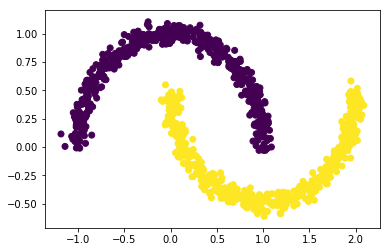

In [174]:
plt.scatter(x=train_X[:, 0], y=train_X[:, 1], c=f_output)

### Question 16 : Complete the code in the box below

###### Describe your protocol here : 
- when lamb is small, the labeled data is emphasized, when lamb_u is small, the structure information is emphasized.

- we take the moons set and fix the training set and testing set, firstly, we trained each model on the same train set, we then predict the test label on the test set.

- you can find three parts in the following: 1) function defines, 2) train models 3) test models. Note that we didn't change the lamb_u and lamb in our test.

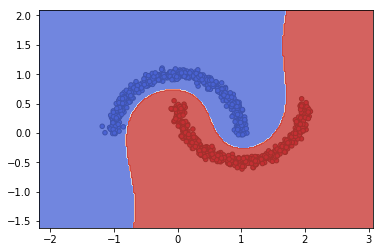

In [175]:
# use the standard plot method of sklearn

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, pred_func, xx, yy, alp, train_X, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = pred_func(train_X, np.c_[xx.ravel(), yy.ravel()], alp, **params)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    return out


# Set-up 2x2 grid for plotting.
fig, ax = plt.subplots(1, 1)
#plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = train_X[:, 0], train_X[:, 1]
xx, yy = make_meshgrid(X0, X1)
ax.scatter(X0, X1, c=f_output, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plot_contours(ax=ax, xx=xx, yy=yy, pred_func=LapSVM_predict, alp=alpha, train_X=train_X)

plt.show()

### Compare Different Algorithms on the Same data Set

### train set

In [176]:
p_unlabel = 0.8
moons = make_moons(n_samples=1000, noise=0.2)
X_lab, X_unlab, y_lab, y_unlab = get_dataset(moons[0], moons[1], p_unlabel)

### train by different models

In [177]:
import time

0.97625 0.955
time used for training: 0.5786120891571045 seconds


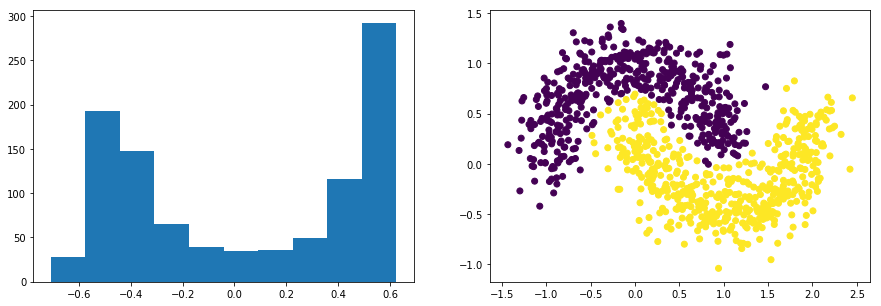

In [178]:
# LapRLS
time_start = time.time()
f_output_LapRLS, acc_LapRLS, acc_lab_LapRLS, alpha_LapRLS, train_X_LapRLS = LapRLS(X_lab, X_unlab, y_lab, y_unlab)
time_length = time.time() - time_start
print("time used for training:", time_length, "seconds")

In [179]:
#self training: X_val , y_val to decide when to stop
p_test = 0.6
X_lab, X_unlab, y_lab, y_unlab = get_dataset(moons[0], moons[1], p_unlabel)
X_lab_train, X_val, y_lab_train, y_val = split_unlabel_set(p_test, X_lab, y_lab)
time_start = time.time()
myneigh, acc = self_training(X_lab_orig=X_lab_train, y_lab_orig=y_lab_train, X_unlab_orig=X_unlab, X_test=X_val, y_test=y_val, tol=1e-4)
time_length = time.time() - time_start
print("time used for training:", time_length, "seconds")

k =  0 , updated classifier on the test set, sim =  0.92012358588 , X_unlab samples = 150
k =  1 , updated classifier on the test set, sim =  0.967412317039 , X_unlab samples = 43
k =  2 , updated classifier on the test set, sim =  1.0 , X_unlab samples = 24
time used for training: 0.06268000602722168 seconds


0.97625 0.955
time used for training: 0.5437710285186768 seconds


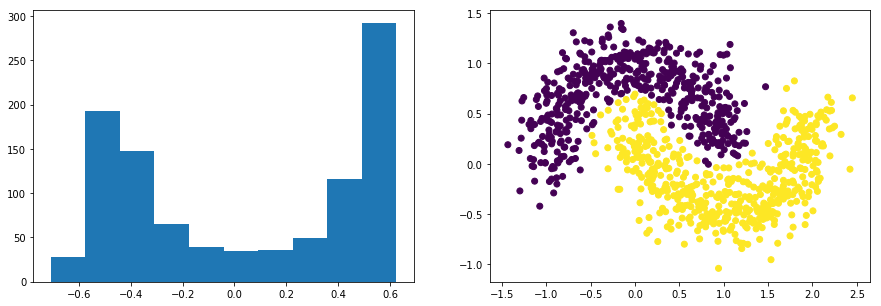

In [180]:
# LapSVM
time_start = time.time()
f_output_LapSVM, acc_LapSVM, acc_lab_LapSVM, alpha_LapSVM, train_X_LapSVM = LapRLS(X_lab, X_unlab, y_lab, y_unlab)
time_length = time.time() - time_start
print("time used for training:", time_length, "seconds")

### Test different models

In [181]:
# test set
moons_test_noise_levels = 10**np.arange(3)*0.002
moons_test_lis = []
for i in moons_test_noise_levels:
    moons_test = make_moons(n_samples=300, noise=i)
    moons_test_lis.append(moons_test)

accuracy = 1.0
accuracy = 1.0
accuracy = 0.956666666667


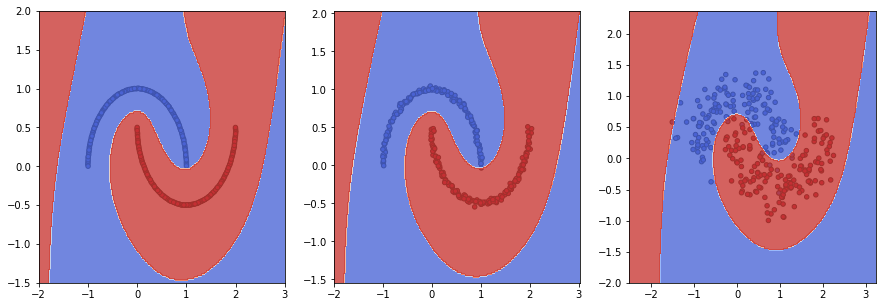

In [182]:
# LapSVM

fig, ax = plt.subplots(1,3, figsize=(15, 5))

for i,moons_test in enumerate(moons_test_lis):
    test_X, test_y = moons_test[0], moons_test[1]
    X0, X1 = test_X[:, 0], test_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    labels = LapSVM_predict(alpha=alpha_LapSVM, new_X=test_X, train_X=train_X_LapSVM)
    # map test labels to {-1, 1}
    test_y = np.array(list(map(lambda x:-1 if x==0 else 1, test_y)))
    print("accuracy =", np.mean(labels.T - test_y == 0))
    ax[i].scatter(X0, X1, c=test_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plot_contours(ax=ax[i], xx=xx, yy=yy, pred_func=LapSVM_predict, alp=alpha_LapSVM, train_X=train_X_LapSVM)

plt.show()

accuracy = 1.0
accuracy = 1.0
accuracy = 0.956666666667


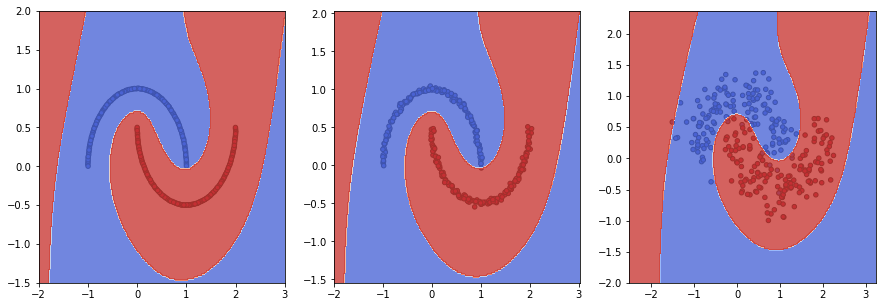

In [185]:
# LapRLS

fig, ax = plt.subplots(1,3, figsize=(15, 5))

for i,moons_test in enumerate(moons_test_lis):
    test_X, test_y = moons_test[0], moons_test[1]
    X0, X1 = test_X[:, 0], test_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    labels = LapRLS_predict(alpha=alpha_LapRLS, new_X=test_X, train_X=train_X_LapRLS)
    # map test labels to {-1, 1}
    test_y = np.array(list(map(lambda x:-1 if x==0 else 1, test_y)))
    print("accuracy =", np.mean(labels.T - test_y == 0))
    ax[i].scatter(X0, X1, c=test_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plot_contours(ax=ax[i], xx=xx, yy=yy, pred_func=LapRLS_predict, alp=alpha_LapRLS, train_X=train_X_LapRLS)

plt.show()

accuracy = 0.993333333333
accuracy = 0.99
accuracy = 0.95


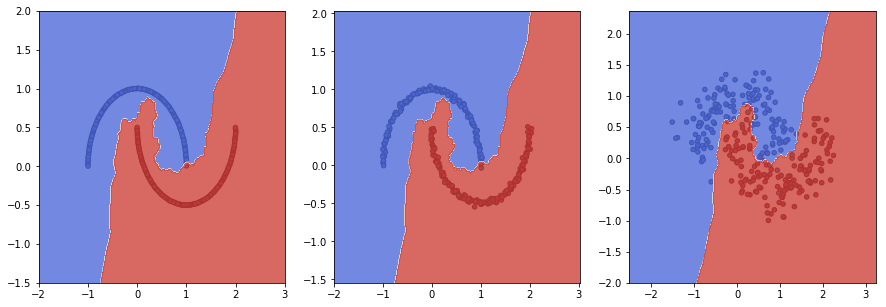

In [186]:
# self_training
def self_training_predict(train_X, new_X, alpha, neigh):
    return neigh.predict(new_X)
    
fig, ax = plt.subplots(1,3, figsize=(15, 5))

for i,moons_test in enumerate(moons_test_lis):
    test_X, test_y = moons_test[0], moons_test[1]
    X0, X1 = test_X[:, 0], test_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    labels = myneigh.predict(test_X)
    print("accuracy =", np.mean(labels.T - test_y == 0))
    ax[i].scatter(X0, X1, c=test_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plot_contours(ax=ax[i], xx=xx, yy=yy, pred_func=self_training_predict, alp=None, train_X=None, neigh=myneigh)

plt.show()

### Remarks: During the training period, on the same training data set, the self-training method is much quicker than the closed-form-solved LapSVM, which is quicker than the closed-form-solved LapRLS. Note that we fixed the hyperparametres for both Laps at lamb=1e-4, lamb_u=1e-2, which may have an influence on the accuracy of the testing period.

- Thanks for your attention !

Yours, 

Xiangnan YUE & Yanlin DU